In [ ]:
# Parameter inputs
aragorn_submit_url = "https://aragorn-u24.apps.renci.org/robokop/query"
trapi_submit_url = "http://automat-u24.apps.renci.org/robokopkg/1.3/query"

automat_cypher_submit_url = 'https://automat.renci.org/robokopkg/cypher'
robokopkg_bolt_url = "bolt://robokopkg.renci.org:7687"

input_search_string = 'ppara'
output_search_string = 'liver fibrosis'

In [ ]:
import requests
import os
import json
import pandas as pd
import pprint
pp = pprint.PrettyPrinter(indent=5)

from datetime import datetime
from pathlib import Path
from collections import Counter

In [ ]:
# Initializing directory to write
now = datetime.now()
dt_string = now.strftime("%Y-%m-%d_%H%M%S")
write_dir_trapi_automat = Path("output/compare/"+str(dt_string)+"/trapi/automat")
write_dir_trapi_automat.mkdir(parents=True, exist_ok=True)

write_dir_trapi_ara = Path("output/compare/"+str(dt_string)+"/trapi/ara")
write_dir_trapi_ara.mkdir(parents=True, exist_ok=True)

write_dir_cypher_automat = Path("output/compare/"+str(dt_string)+"/cypher/automat")
write_dir_cypher_automat.mkdir(parents=True, exist_ok=True)

write_dir_cypher_robokopkg = Path("output/compare/"+str(dt_string)+"/cypher/robokopkg")
write_dir_cypher_robokopkg.mkdir(parents=True, exist_ok=True)

In [ ]:
# Pathway results to load
ARA_results_file = "output/compare/"+str(dt_string)+"/trapi/ara/results_ARA.csv"
TRAPI_results_file = "output/compare/"+str(dt_string)+"/trapi/automat/results_TRAPI.csv"
Cypher_ROBOKOPKG_results_file = "output/compare/"+str(dt_string)+"/cypher/robokopkg/results.csv"
Cypher_Automat_results_file = "output/compare/"+str(dt_string)+"/cypher/automat/results.csv"
exemplar_results_file = "output/compare/"+str(dt_string)+"/exemplar_data.csv"

In [87]:
# Pathway results to load and write directory to specify (on David's work computer from previous run)
write_dir_cypher_automat = "output/compare/2023-07-07_153233/cypher/automat"
write_dir_cypher_robokopkg = "output/compare/2023-07-07_153233/cypher/robokopkg"
ARA_results_file = "output/compare/2023-07-07_153233/trapi/ara/results_ARA.csv"
TRAPI_results_file = "output/compare/2023-07-07_153233/trapi/automat/results_TRAPI.csv"
Cypher_ROBOKOPKG_results_file = "output/compare/2023-07-07_153233/cypher/robokopkg/results.csv"
Cypher_Automat_results_file = "output/compare/2023-07-07_153233/cypher/automat/results.csv"
write_dir_compare = "output/compare/2023-07-07_153233"
exemplar_results_file = "output/compare/2023-07-07_153233/exemplar_data.csv"
qbuilder_bio_entity_results_file = "output/compare/2023-07-07_153233/qbuilder_bio_entity_data.csv"
qbuilder_blank_results_file = "output/compare/2023-07-07_153233/qbuilder_blank_data.csv"

In [ ]:
# Initializing Neo4j connection class
user = 'neo4j'
pw = ''

from neo4j import GraphDatabase
class Neo4jConnection:
    
    def __init__(self, uri, user, pwd):
        self.__uri = uri
        self.__user = user
        self.__pwd = pwd
        self.__driver = None
        try:
            self.__driver = GraphDatabase.driver(self.__uri, auth=(self.__user, self.__pwd))
        except Exception as e:
            print("Failed to create the driver:", e)
        
    def close(self):
        if self.__driver is not None:
            self.__driver.close()
        
    def query(self, query, db=None):
        assert self.__driver is not None, "Driver not initialized!"
        session = None
        response = None
        try: 
            session = self.__driver.session(database=db) if db is not None else self.__driver.session()
            response = list(session.run(query))
        except Exception as e:
            print("Query failed:", e)
        finally: 
            if session is not None:
                session.close()
        return response

## Generating data for comparison

### Getting "Input/Output" CURIES

In [ ]:
results = requests.post(f'https://name-resolution-sri.renci.org/lookup?string={input_search_string}&offset=0&limit=100')
results_json = results.json()
#print(json.dumps(results_json,indent=4))
input_node_id_list = list(results_json.keys())
print(input_node_id_list)
print(f"Number of 'input' IDs: {len(input_node_id_list)}")

In [ ]:
results = requests.post(f'https://name-resolution-sri.renci.org/lookup?string={output_search_string}&offset=0&limit=100')
results_json = results.json()
#print(json.dumps(results_json,indent=4))
output_node_id_list = list(results_json.keys())
print(output_node_id_list)
print(f"Number of 'output' IDs: {len(output_node_id_list)}")

### TRAPI methods

In [ ]:
# Initializing TRAPI query and extracting results for ARA and Automat
query={
    "message": {
      "query_graph": {
        "edges": {
          "e00": {
            "subject": "n00",
              "object": "n01",
          "predicates":["biolink:related_to"]
          },
          "e01": {
            "subject": "n01",
              "object": "n02",
          "predicates":["biolink:related_to"]
          }
        },
        "nodes": {
          "n00": {
            "ids": input_node_id_list, #['NCBIGene:5465'], #
            "categories": ["biolink:GeneOrGeneProduct"]
          },
          "n01": {
              "categories": ["biolink:BiologicalEntity"]
          },
          "n02": {
            "ids": output_node_id_list, #["HP:0001395"],
            "categories": ["biolink:DiseaseOrPhenotypicFeature"]
          }
        }
      }
    }
  }


In [ ]:
response_trapi = requests.post(trapi_submit_url,json=query)
print(response_trapi.status_code)
number_pathway_results_trapi = len(response_trapi.json()['message']['results'])
print(len(response_trapi.json()['message']['results']))

In [ ]:
kg_trapi = response_trapi.json()['message']['knowledge_graph']
results_trapi = response_trapi.json()['message']['results']

In [ ]:
import pandas as pd
import os

cols = []
for node in sorted(results_trapi[0]['node_bindings'].keys()):
    cols.append(node)
    cols.append(node + '_name')
results_trapi_df = pd.DataFrame(columns = cols)

results_trapi_list = []
for result in results_trapi:
    result_dict = {}
    for node in sorted(result['node_bindings'].keys()):
        node_id = result['node_bindings'][node][0]['id']
        result_dict[node] = node_id
        result_dict[node + '_name'] = kg_trapi['nodes'][node_id]['name']

    results_trapi_list.append(pd.DataFrame([result_dict]))
results_trapi_df = pd.concat(results_trapi_list)
display(results_trapi_df)
# results_trapi_df.to_csv(os.path.join(write_dir_trapi_automat,'results_TRAPI.csv'), index=False)
results_trapi_df.to_csv(TRAPI_results_file, index=False)

combined_node_list = ["_".join([row[1].replace(" ", "_"), row[3].replace(" ", "_"), row[5].replace(" ", "_")]) for row in results_trapi_df[cols].to_numpy()]
pp.pprint(combined_node_list)

In [ ]:
from collections import Counter
import json
import pprint
pp = pprint.PrettyPrinter(indent=5)

for i in range(number_pathway_results_trapi):
    print(f"Pathway result: {combined_node_list[i]}")
    edge_bindings = results_trapi[i]['edge_bindings']

    edge_ids = []
    for edge_name, edge_list in edge_bindings.items():
        edge_ids.append({edge_name: [x['id'] for x in edge_list]})

    string_out_list = []
    for edge_dict in edge_ids:
        for edge_name, edge_list in edge_dict.items():
            for edge_id in edge_list:
                subject_id = kg_trapi['edges'][edge_id]['subject']
                subject = kg_trapi['nodes'][subject_id]['name']
                predicate = kg_trapi['edges'][edge_id]['predicate']
                object_id = kg_trapi['edges'][edge_id]['object']
                object = kg_trapi['nodes'][object_id]['name']
                string_out = f"{subject} -> {predicate} -> {object}"
                string_out_list.append(string_out)
    string_out_dict = dict(Counter(string_out_list).items())
    pp.pprint(string_out_dict)
    print("")
    
    with open(os.path.join(write_dir_trapi_automat,combined_node_list[i]+".txt"), 'a') as convert_file:
        convert_file.write(json.dumps(string_out_dict))
        

In [ ]:
response_ara = requests.post(aragorn_submit_url,json=query)
print(response_ara.status_code)
number_pathway_results_ara = len(response_ara.json()['message']['results'])
print(len(response_ara.json()['message']['results']))

In [ ]:
kg_ara = response_ara.json()['message']['knowledge_graph']
results_ara = response_ara.json()['message']['results']

In [ ]:
import pandas as pd
import os

cols = []
for node in sorted(results_ara[0]['node_bindings'].keys()):
    cols.append(node)
    cols.append(node + '_name')
results_ara_df = pd.DataFrame(columns = cols)

results_ara_list = []
for result in results_ara:
    result_dict = {}
    for node in sorted(result['node_bindings'].keys()):
        node_id = result['node_bindings'][node][0]['id']
        result_dict[node] = node_id
        result_dict[node + '_name'] = kg_ara['nodes'][node_id]['name']

    results_ara_list.append(pd.DataFrame([result_dict]))
results_ara_df = pd.concat(results_ara_list)
display(results_ara_df)
# results_ara_df.to_csv(os.path.join(write_dir_trapi_ara,'results_ARA.csv'), index=False)
results_ara_df.to_csv(ARA_results_file, index=False)

combined_node_list = ["_".join([row[1].replace(" ", "_"), row[3].replace(" ", "_"), row[5].replace(" ", "_")]) for row in results_ara_df[cols].to_numpy()]
pp.pprint(combined_node_list)

In [ ]:
from collections import Counter
import json
import pprint
pp = pprint.PrettyPrinter(indent=5)

for i in range(number_pathway_results_ara):
    print(f"Pathway result: {combined_node_list[i]}")
    edge_bindings = results_ara[i]['edge_bindings']

    edge_ids = []
    for edge_name, edge_list in edge_bindings.items():
        edge_ids.append({edge_name: [x['id'] for x in edge_list]})

    string_out_list = []
    for edge_dict in edge_ids:
        for edge_name, edge_list in edge_dict.items():
            for edge_id in edge_list:
                subject_id = kg_ara['edges'][edge_id]['subject']
                subject = kg_ara['nodes'][subject_id]['name']
                predicate = kg_ara['edges'][edge_id]['predicate']
                object_id = kg_ara['edges'][edge_id]['object']
                object = kg_ara['nodes'][object_id]['name']
                string_out = f"{subject} -> {predicate} -> {object}"
                string_out_list.append(string_out)
    string_out_dict = dict(Counter(string_out_list).items())
    pp.pprint(string_out_dict)
    print("")
    
    with open(os.path.join(write_dir_trapi_ara,combined_node_list[i]+".txt"), 'a') as convert_file:
        convert_file.write(json.dumps(string_out_dict))
        

### Cypher methods

In [ ]:
# Initializing Cypher query and extracting results from Automat using Cypher

nodes = ['n00','n01','n02']
cols = []
for node in nodes:
    cols.append(node)
    cols.append(node+"_name")

results_df = pd.DataFrame(columns = cols)
results_dict_list = []

i = 0
for input_node_id in input_node_id_list:
    if i > 0:
        break
    for output_node_id in output_node_id_list:
        if i > 0:
            break
        cypher = f"""MATCH ({nodes[0]}:`biolink:GeneOrGeneProduct`)-[r0_0]-({nodes[1]}:`biolink:BiologicalEntity`)-[r1_0]-({nodes[2]}:`biolink:DiseaseOrPhenotypicFeature`) 
        WHERE {nodes[0]}.id IN ['{input_node_id}'] AND {nodes[2]}.id IN ['{output_node_id}'] 
        RETURN [startNode(r0_0),[type(r0_0),properties(r0_0)],endNode(r0_0)] as edge_1, 
        [startNode(r1_0),[type(r1_0),properties(r1_0)],endNode(r1_0)] as edge_2, 
        [{nodes[0]}.name, {nodes[1]}.name, {nodes[2]}.name] as node_names,
        [{nodes[0]}.id, {nodes[1]}.id, {nodes[2]}.id] as node_ids LIMIT 100"""
        # print(f"{input_node_id}-{output_node_id}")
        j = {'query': cypher}
        # TO-DO:
        # - change timeout value for API call
        # - add sleep call (30s to 60s) at end of each iteration of loop
        try:
            results = requests.post(automat_cypher_submit_url,json=j, timeout=(40,200))
        except requests.ConnectionError:
            sleep(60)
            results = requests.post(automat_cypher_submit_url,json=j, timeout=(40,200))
        # print(results.status_code)
        
        try:
            results_json = results.json()
        except json.decoder.JSONDecodeError:
            print(f"JSON Decode Error: {input_node_id}-{output_node_id}")
            
        string_out_list = []
        # pp.pprint(results_json)
        for result in results_json['results'][0]['data']:
            for item in result['row'][0:2]:
                string_out = f"{item[0]['name']} -> {item[1][0]} -> {item[2]['name']}||{item[1][1]}"
                if string_out not in string_out_list:
                    string_out_list.append(string_out)
        if len(results_json['results'][0]['data']) > 0:
            combined_node_list = "_".join(results_json['results'][0]['data'][0]['row'][2]).replace(" ", "_")
            # print(combined_node_list)

        string_out_list = [i.split('||', 1)[0] for i in string_out_list]

        string_out_dict = dict(Counter(string_out_list).items())
        if len(string_out_dict.keys()) == 0:
            pass
            # print(f"None found for {input_node_id}-{output_node_id}")
        else:
            combined_node_list = "_".join(results_json['results'][0]['data'][0]['row'][2]).replace(" ", "_")
            print(combined_node_list)

            string_out_list = [i.split('||', 1)[0] for i in string_out_list]

            string_out_dict = dict(Counter(string_out_list).items())
            pp.pprint(string_out_dict)
            # i = i + 1

            with open(os.path.join(write_dir_cypher_automat,combined_node_list+".txt"), 'a') as convert_file:
                convert_file.write(json.dumps(string_out_dict))
            
            result_dict = {}
            for j in range(len(nodes)):
                node_id = results_json['results'][0]['data'][0]['row'][3][j]
                node_name = results_json['results'][0]['data'][0]['row'][2][j]
                result_dict[nodes[j]] = node_id
                result_dict[nodes[j]+"_name"] = node_name
            pp.pprint(result_dict)

            results_dict_list.append(result_dict)

results_df = pd.concat([results_df,pd.DataFrame.from_records(results_dict_list)])
print(results_df.shape)
# results_df.to_csv(os.path.join(write_dir_cypher_automat,'results.csv'))
results_df.to_csv(Cypher_Automat_results_file)

In [ ]:
# Saving results if above failed
results_df = pd.DataFrame(columns = cols)
results_df = pd.concat([results_df,pd.DataFrame.from_records(results_dict_list)])
print(results_df.shape)
# results_df.to_csv(os.path.join(write_dir_cypher_automat,'results.csv'))
results_df.to_csv(Cypher_Automat_results_file)

In [ ]:
# Initializing Cypher query and extracting results from ROBOKOPKG using Bolt protocol method
conn = Neo4jConnection(uri=robokopkg_bolt_url, user = user, pwd = pw)

nodes = ['n00','n01','n02']

cols = []
for node in nodes:
    cols.append(node)
    cols.append(node+"_name")

results_df = pd.DataFrame(columns = cols)
results_dict_list = []

i = 0
for input_node_id in input_node_id_list:
    if i > 0:
        break
    for output_node_id in output_node_id_list:
        if i > 0:
            break
        cypher = f"""MATCH ({nodes[0]}:`biolink:GeneOrGeneProduct`)-[r0_0]-({nodes[1]}:`biolink:BiologicalEntity`)-[r1_0]-({nodes[2]}:`biolink:DiseaseOrPhenotypicFeature`) 
        WHERE {nodes[0]}.id IN ['{input_node_id}'] AND {nodes[2]}.id IN ['{output_node_id}'] 
        RETURN [startNode(r0_0),[type(r0_0),properties(r0_0)],endNode(r0_0)] as edge_1, 
        [startNode(r1_0),[type(r1_0),properties(r1_0)],endNode(r1_0)] as edge_2, 
        [{nodes[0]}.name, {nodes[1]}.name, {nodes[2]}.name] as node_names,
        [{nodes[0]}.id, {nodes[1]}.id, {nodes[2]}.id] as node_ids LIMIT 100"""
        record_list = conn.query(cypher)
        
        string_out_list = []
        for record in record_list: 
            record_data = record.data()
            #only grab the edge information and skip the node names and IDs
            record_data_first2 = {k: record_data[k] for k in list(record_data)[:2]}
            for label, data in record_data_first2.items():
                string_out = f"{label} - {data[0]['name']} -> {data[1][0]} -> {data[2]['name']}||{data[1][1]}"
                if string_out not in string_out_list:
                    string_out_list.append(string_out)

        if len(record_list) > 0:
            combined_node_list = "_".join(list(record_list[0].data('node_names').values())[0])
            print(combined_node_list)

            string_out_list = [i.split('||', 1)[0] for i in string_out_list]

            string_out_dict = dict(Counter(string_out_list).items())
            pp.pprint(string_out_dict)

            with open(os.path.join(write_dir_cypher_robokopkg,combined_node_list+".txt"), 'a') as convert_file:
                convert_file.write(json.dumps(string_out_dict))
        
        for record in record_list:
            # print(f"{input_node_id} - {output_node_id}")
            record_data = record.data()
            #only grab the node labels and IDs
            record_data_last2 = {k: record_data[k] for k in list(record_data)[2:]}

            result_dict = {}
            for label, data in record_data_last2.items():
                # print(f"{label}: {data}")
                for j in range(len(nodes)):
                    if "ids" in label:
                        node_id = data[j]
                        result_dict[nodes[j]] = node_id
                    elif "names" in label:
                        node_name = data[j]
                        result_dict[nodes[j]+"_name"] = node_name
            # pp.pprint(result_dict)

            results_dict_list.append(result_dict)

results_df = pd.concat([results_df,pd.DataFrame.from_records(results_dict_list)])
print(results_df.shape)
display(results_df)
# results_df.to_csv(os.path.join(write_dir_cypher_robokopkg,'results.csv'))
results_df.to_csv(Cypher_ROBOKOPKG_results_file)
conn.close()

In [ ]:
import pandas as pd

def get_summary_stats(results_df):
    results_df['Freq'] = 1

    occur_n00=(results_df
      .groupby(
           results_df[["n00"]]
           .apply(lambda x: str(sorted(x)), axis=1)
           )
      .agg({"n00": "first", "n00_name": "first", "Freq": "sum"}).sort_values(['Freq'], ascending = False)
      .reset_index(drop=True)
    )
    occur_n02=(results_df
      .groupby(
           results_df[["n02"]]
           .apply(lambda x: str(sorted(x)), axis=1)
           )
      .agg({"n02": "first","n02_name": "first", "Freq": "sum"}).sort_values(['Freq'], ascending = False)
      .reset_index(drop=True)
    )
    
    # Counting pairwise results
    occur_pair=(results_df
      .groupby(
           results_df[["n00", "n02"]]
           .apply(lambda x: str(sorted(x)), axis=1)
           )
      .agg({"n00": "first", "n00_name": "first", "n02": "first", "n02_name": "first", "Freq": "sum"}).sort_values(['Freq'], ascending = False)
      .reset_index(drop=True)
    )

    print("\nFrequency of n00 IDs")
    display(occur_n00)
    print("\nFrequency of n02 IDs")
    display(occur_n02)
    print("\nFrequency of n00-n02 pair IDs")
    display(occur_pair)
    
    print("\nMost frequent pair")
    display(occur_pair.head(1))
    return(occur_pair.head(1))
    
def compare_summary_stats(results_df1, results_df2, label1, label2):
    print(f"Summary stats for {label1}")
    most_frequent_pair1 = get_summary_stats(results_df1)
    most_frequent_pair1['label'] = label1
    print(f"\nSummary stats for {label2}")
    most_frequent_pair2 = get_summary_stats(results_df2)
    most_frequent_pair2['label'] = label2
    frames = [most_frequent_pair1,most_frequent_pair2]
    most_frequent_pairs = pd.concat(frames)
    display(most_frequent_pairs)

In [ ]:
results_df_Cypher_Automat = pd.read_csv(Cypher_Automat_results_file)
display(results_df_Cypher_Automat)
most_common_pair_test = get_summary_stats(results_df_Cypher_Automat)

## TRAPI comparison results
ARA vs TRAPI

In [ ]:
results_df_ARA = pd.read_csv(ARA_results_file)
results_df_TRAPI = pd.read_csv(TRAPI_results_file)
compare_summary_stats(results_df_ARA,results_df_TRAPI,"ARA","TRAPI (automat)")

## Cypher comparison results
Automat vs Bolt

In [ ]:
results_df_Cypher_Automat = pd.read_csv(Cypher_Automat_results_file)
results_df_Cypher_ROBOKOPKG = pd.read_csv(Cypher_ROBOKOPKG_results_file)
compare_summary_stats(results_df_Cypher_Automat,results_df_Cypher_ROBOKOPKG,"Cypher (automat)","Cypher (ROBOKOPKG)")

## Automat comparison results
TRAPI vs Cypher

In [ ]:
results_df_TRAPI = pd.read_csv(TRAPI_results_file)
results_df_Cypher_Automat = pd.read_csv(Cypher_Automat_results_file)
compare_summary_stats(results_df_TRAPI,results_df_Cypher_Automat,"TRAPI (automat)","Cypher (automat)")

## Comparison plots

In [88]:
results_df_ARA = pd.read_csv(ARA_results_file)
results_df_TRAPI = pd.read_csv(TRAPI_results_file)
results_df_Cypher_Automat = pd.read_csv(Cypher_Automat_results_file)
results_df_Cypher_ROBOKOPKG = pd.read_csv(Cypher_ROBOKOPKG_results_file)
results_df_exemplar = pd.read_csv(exemplar_results_file)
results_df_qbuilder_bio_entity = pd.read_csv(qbuilder_bio_entity_results_file)
results_df_qbuilder_blank = pd.read_csv(qbuilder_blank_results_file)

In [ ]:
display(results_df_ARA)

In [80]:
# library and defining compare_results() function for later demo use
import matplotlib.pyplot as plt
import sys
from matplotlib_venn import venn2

def compare_results(df1, df2, output_file_name, label1, label2):
    # This function takes the results of two dictionaries created by the TRAPI and Cypher query Jupyter notebooks and gets the following:
    #  -finds how many edges each set has in common, including having the same and different number of occurrences
    #  -finds edges exclusive to each set
    #  -plots a venn diagram representation of common edges and differences between sets
    #    -edges with the same predicate but different occurrences are treated as differences in the diagram
    # INPUT:
    #  -df1: dictionary with keys in the format of "node_label_1 -> predicate -> node_label_2" and corresponding values being occurrences within that set
    #  -df2: dictionary with keys in the format of "node_label_1 -> predicate -> node_label_2" and corresponding values being occurrences within that set
    #  -output_file_name: name of the file to write to with output results
    #  -label1/label2: Text and figure label for first and second input dictionaries, respectively
    # OUTPUT:
    #  -compare .txt file listing each of the following:
    #    -Common edges
    #    -Common edge predicates with different counts
    #    -Edges exclusive to the first input dictionary
    #    -Edges exclusive to the second input dictionary
    #  -Venn diagram showing number of common and different edges between the two input sets
    with open(output_file_name, "w") as f:
        # col1 = df1.apply(lambda row: '-'.join([row['n00'],row['n01'],row['n02']]), axis=1)
        # col2 = df2.apply(lambda row: '-'.join([row['n00'],row['n01'],row['n02']]), axis=1)
        col1 = df1.apply(lambda row: '-'.join([row['n00_name'],row['n01_name'],row['n02_name']]), axis=1)
        col2 = df2.apply(lambda row: '-'.join([row['n00_name'],row['n01_name'],row['n02_name']]), axis=1)

        pathways_in_common_list = list(set(col1) & set(col2))
        pathways_col1_list = list(set(col1) - set(col2))
        pathways_col2_list = list(set(col2) - set(col1))

        f.write("Common pathways:\n")
        for pathway in pathways_in_common_list:
            f.write(pathway)
            f.write("\n")
        f.write(f"\n{label1} only:\n")
        for pathway in pathways_col1_list:
            f.write(pathway)
            f.write("\n")
        f.write(f"\n{label2} only:\n")
        for pathway in pathways_col2_list:
            f.write(pathway)
            f.write("\n")
    
    venn2(subsets = (len(pathways_col1_list), len(pathways_col2_list), len(pathways_in_common_list)), set_labels = (label1, label2))
    plt.savefig(output_file_name.replace(".txt","_venn.png"))
    plt.show()
    
    col3 = col1.value_counts()
    col4 = col2.value_counts()
        
    df_merge_input = pd.DataFrame([col3,col4]).T
    df_merge_input.columns = [label1,label2]
    df_merge_input[label1][df_merge_input[label1].isnull()] = 0
    df_merge_input[label2][df_merge_input[label2].isnull()] = 0
    df_merge_input['set_difference'] = df_merge_input[label2] - df_merge_input[label1]
    display(df_merge_input)

    y = df_merge_input['set_difference']
    x = df_merge_input.index.values.tolist()
    plt.figure()
    plt.barh(x,y)
    plt.gca().invert_yaxis()
    plt.xlabel(f'{label1} vs {label2}')
    # plt.title("Automat vs ROBOKOPKG")
    # plt.tick_params(left = False, labelleft = False)
    max_set_difference = max(df_merge_input['set_difference'])
    min_set_difference = min(df_merge_input['set_difference'])
    plt.xlim([min(-3,min_set_difference),max(3,max_set_difference)])
    plt.savefig(output_file_name.replace(".txt","_diffplot.png"), bbox_inches="tight")

        

In [ ]:
# ARA and Cypher (robokopkg) sets
output_file_name = os.path.join(write_dir_compare,"compare_ara_vs_cypher-robokopkg.txt")
compare_results(results_df_ARA,results_df_Cypher_ROBOKOPKG, output_file_name, "ARA", "Cypher (ROBOKOPKG)")

In [ ]:
# ARA and TRAPI
output_file_name = os.path.join(write_dir_compare,"compare_ara_vs_trapi.txt")
compare_results(results_df_ARA,results_df_TRAPI, output_file_name, "ARA", "TRAPI")

In [ ]:
# Cypher (automat) and Cypher (robokopkg) sets
output_file_name = os.path.join(write_dir_compare,"compare_cypher-automat_vs_cypher-robokopkg.txt")
compare_results(results_df_Cypher_Automat,results_df_Cypher_ROBOKOPKG, output_file_name, "Cypher (Automat)", "Cypher (ROBOKOPKG)")

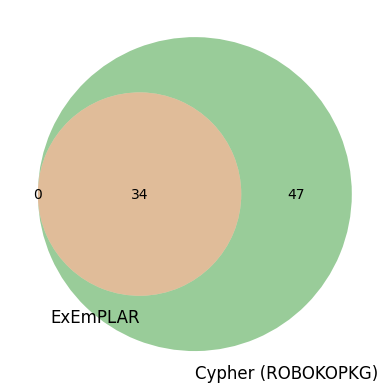

,ExEmPLAR,Cypher (ROBOKOPKG),set_difference
PPARA-ALB-Hepatic fibrosis,3.0,3.0,0.0
PPARA-AGT-Hepatic fibrosis,3.0,3.0,0.0
PPARA-SPP1-Hepatic fibrosis,3.0,3.0,0.0
PPARA-ABCB4-Hepatic fibrosis,2.0,2.0,0.0
PPARA-REN-Hepatic fibrosis,2.0,2.0,0.0
...,...,...,...
PPARGC1A-IL6-Hepatic fibrosis,0.0,1.0,1.0
PPARGC1A-MMP2-Hepatic fibrosis,0.0,1.0,1.0
PPARGC1A-ARNT-Hepatic fibrosis,0.0,1.0,1.0
PPARGC1A-AGT-Hepatic fibrosis,0.0,1.0,1.0


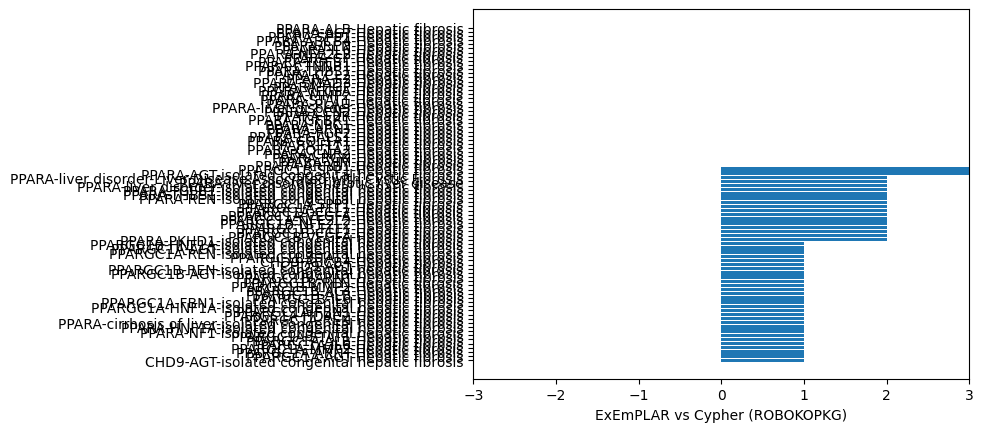

In [81]:
# ARA and Cypher (robokopkg) sets
results_df_exemplar_names = results_df_exemplar[[c for c in results_df_exemplar.columns if "_name" in c]]
output_file_name = os.path.join(write_dir_compare,"compare_exemplar_vs_cypher-robokopkg.txt")
compare_results(results_df_exemplar_names,results_df_Cypher_ROBOKOPKG, output_file_name, "ExEmPLAR", "Cypher (ROBOKOPKG)")

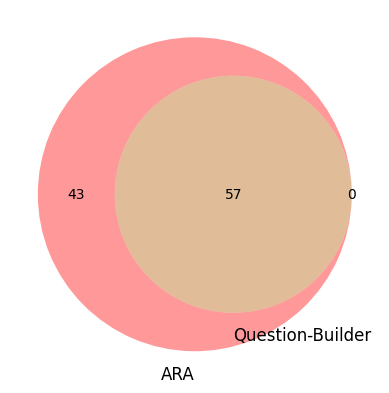

,ARA,Question-Builder,set_difference
peroxisome proliferator-activated receptor alpha isoform 1 (human)-AGT-isolated congenital hepatic fibrosis,6.0,1.0,-5.0
PPARA-liver disorder-isolated congenital hepatic fibrosis,4.0,1.0,-3.0
PPARA-NF1-isolated congenital hepatic fibrosis,4.0,1.0,-3.0
PPARA-cirrhosis of liver-isolated congenital hepatic fibrosis,4.0,1.0,-3.0
PPARA-PKHD1-isolated congenital hepatic fibrosis,4.0,1.0,-3.0
...,...,...,...
PPARGC1B-AGT-Hepatic fibrosis,1.0,0.0,-1.0
PPARGC1A-REN-Hepatic fibrosis,1.0,0.0,-1.0
PPARGC1A-FLT1-Hepatic fibrosis,1.0,0.0,-1.0
PPARGC1A-STAT1-Hepatic fibrosis,1.0,0.0,-1.0


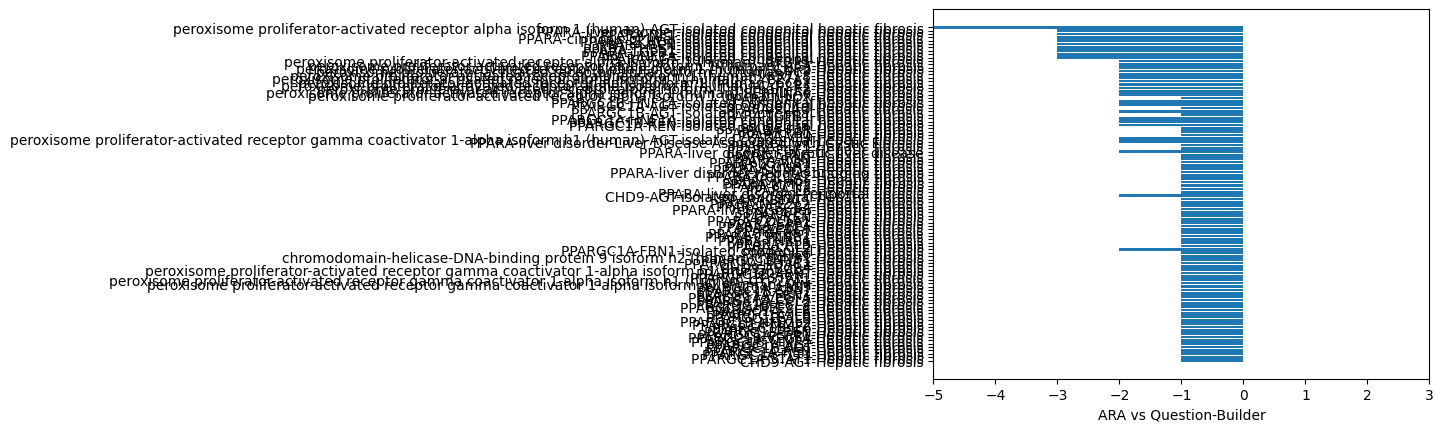

In [84]:
# ARA and Question Builder (Biological Entity) sets
output_file_name = os.path.join(write_dir_compare,"compare_ARA_vs_qbuilder_bio_entity.txt")
compare_results(results_df_ARA,results_df_qbuilder_bio_entity, output_file_name, "ARA", "Question-Builder (Biological Entity)")

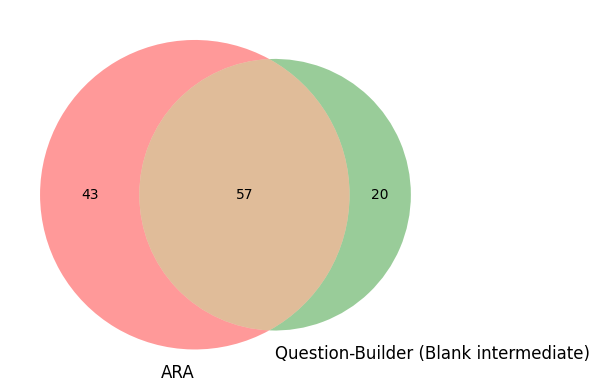

,ARA,Question-Builder (Blank intermediate),set_difference
peroxisome proliferator-activated receptor alpha isoform 1 (human)-AGT-isolated congenital hepatic fibrosis,6.0,1.0,-5.0
PPARA-liver disorder-isolated congenital hepatic fibrosis,4.0,1.0,-3.0
PPARA-NF1-isolated congenital hepatic fibrosis,4.0,1.0,-3.0
PPARA-cirrhosis of liver-isolated congenital hepatic fibrosis,4.0,1.0,-3.0
PPARA-PKHD1-isolated congenital hepatic fibrosis,4.0,1.0,-3.0
...,...,...,...
PPARA-Fenofibrate-Hepatic fibrosis,0.0,1.0,1.0
PPARA-Efavirenz-Hepatic fibrosis,0.0,1.0,1.0
PPARA-Telmisartan-isolated congenital hepatic fibrosis,0.0,1.0,1.0
PPARA-Azathioprine-Hepatic fibrosis,0.0,1.0,1.0


In [ ]:
# ARA and Question Builder (Blank intermediate) sets
output_file_name = os.path.join(write_dir_compare,"compare_ARA_vs_qbuilder_blank.txt")
compare_results(results_df_ARA,results_df_qbuilder_blank, output_file_name, "ARA", "Question-Builder (Blank intermediate)")